In [1]:
import os
import glob
import re
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
from sunpy.map import Map, make_fitswcs_header
from sunpy.coordinates import HeliographicCarrington, sun

In [8]:
# --- Configuration ---
INPUT_FOLDER = '/home/prateekmayank/surya_workshop/data/target_dataset/wsa_opt_maps'                   # Folder containing .npy files
OUTPUT_FOLDER = 'wsa_full_disk'      # Folder to save the results
TARGET_RESOLUTION = 0.6            # Arcsec/pixel for output
OUTPUT_SHAPE = (4096, 4096)        # Dimensions of output map

def get_cr_mid_date(cr_number):
    """
    Returns the date corresponding to the middle of a Carrington Rotation.
    Start time + 13.6 days (half a solar rotation).
    """
    # Get start time of the rotation (Longitude 360)
    start_time = sun.carrington_rotation_time(cr_number)
    # Add half a rotation period (~13.6 days) to get the center
    mid_time = start_time + TimeDelta(13.6 * u.day)
    return mid_time

def reproject_speed_to_aia(speed_data, target_date):
    """
    Reprojects a 2D WSA optimized speed map (Carrington) to an Earth-view Full Disk.
    """
    # 1. Handle Orientation: Ensure shape matches (Lat, Lon) for SunPy creation
    # If data is (360, 180) -> it's likely (Lon, Lat), so we transpose to (180, 360)
    if speed_data.shape == (360, 180):
        speed_data = speed_data.T
    
    input_shape = speed_data.shape  # Should be roughly (180, 360)

    # 2. Create Input Header (Carrington Frame)
    # CRITICAL FIX: observer="self" with a defined radius anchors the map in 3D
    carrington_frame = HeliographicCarrington(obstime=target_date, observer="self")
    
    input_coord = SkyCoord(180 * u.deg, 0 * u.deg, 1 * u.R_sun, 
                           frame=carrington_frame)
    
    input_header = make_fitswcs_header(
        input_shape,
        input_coord,
        scale=[1, 1] * u.deg / u.pix,  # Assuming 1 degree/pixel resolution
        projection_code="CAR",
        instrument="WSA+ Optimized"
    )
    
    # Create the Map
    input_map = Map(speed_data, input_header)
    input_map.meta['rsun_ref'] = 6.96e8  # Standard solar radius in meters

    # 3. Define Output Header (Virtual AIA View from Earth)
    target_scale = u.Quantity([TARGET_RESOLUTION, TARGET_RESOLUTION], unit=u.arcsec / u.pix)
    
    # Center the view on Earth at the target date
    ref_coord = SkyCoord(0 * u.arcsec, 0 * u.arcsec, 
                         frame="helioprojective", 
                         obstime=target_date, 
                         observer='earth')

    output_header = make_fitswcs_header(
        OUTPUT_SHAPE,
        ref_coord,
        scale=target_scale,
        projection_code="TAN", 
        instrument=f"Virtual AIA {TARGET_RESOLUTION}"
    )

    output_template = Map(np.zeros(OUTPUT_SHAPE), output_header)

    # 4. Reproject
    # interpolation='linear' (or 'bilinear') is standard and faster than adaptive
    print(f"   Reprojecting to {OUTPUT_SHAPE}...")
    full_disk_map = input_map.reproject_to(output_template.wcs, algorithm='interpolation')
    
    return full_disk_map

def main():
    if not os.path.exists(OUTPUT_FOLDER):
        os.makedirs(OUTPUT_FOLDER)

    # Find all .npy files
    file_list = sorted(glob.glob(os.path.join(INPUT_FOLDER, "*.npy")))
    
    if not file_list:
        print(f"No .npy files found in {INPUT_FOLDER}")
        return

    print(f"Found {len(file_list)} maps to process.")

    target_files = file_list[::10]

    for i, file_path in enumerate(target_files):
        filename = os.path.basename(file_path)
        
        # --- 1. Extract CR Number ---
        # Regex looks for "CR" followed by digits (e.g., CR2049)
        match = re.search(r'CR(\d+)', filename)
        
        if not match:
            print(f"[{i+1}] Skipping {filename}: Could not find 'CR' number in name.")
            continue
            
        cr_num = int(match.group(1))
        
        print(f"\n[{i+1}/{len(file_list)}] Processing CR{cr_num} ({filename})...")

        try:
            # --- 2. Calculate Date ---
            # Get the mid-point date of this Carrington Rotation
            target_date = get_cr_mid_date(cr_num)
            print(f"   Target Date (Mid-CR): {target_date.iso}")

            # --- 3. Load Data ---
            speed_data = np.load(file_path)
            # Nan handling: set NaNs to 0 (or min speed) to avoid projection errors
            speed_data = np.nan_to_num(speed_data, nan=0.0)

            # --- 4. Reproject ---
            reprojected_map = reproject_speed_to_aia(speed_data, target_date)

            # --- 5. Save to CSV ---
            # Construct output filename
            output_filename = f"reprojected_wsa_CR{cr_num}.csv"
            output_path = os.path.join(OUTPUT_FOLDER, output_filename)
            
            print(f"   Saving to {output_path}...")
            print("   (Warning: File will be approx 300MB)")
            
            # Save data with 4 decimal places to save some space/time
            np.savetxt(output_path, reprojected_map.data, delimiter=',', fmt='%.4f')
            
            print("   Done.")

        except Exception as e:
            print(f"   Error processing CR{cr_num}: {e}")

    print("\nProcessing Complete.")

if __name__ == "__main__":
    main()

Found 129 maps to process.

[1/129] Processing CR2049 (fittedCR2049_wsa_map.npy)...
   Target Date (Mid-CR): 2006-11-01 03:35:09.625
   Reprojecting to (4096, 4096)...


   Saving to wsa_full_disk/reprojected_wsa_CR2049.csv...
   (Warning: File will be approx 300MB)
   Done.

[2/129] Processing CR2062 (fittedCR2062_wsa_map.npy)...
   Target Date (Mid-CR): 2007-10-21 17:18:48.054
   Reprojecting to (4096, 4096)...


   Saving to wsa_full_disk/reprojected_wsa_CR2062.csv...
   (Warning: File will be approx 300MB)
   Done.

[3/129] Processing CR2073 (fittedCR2073_wsa_map.npy)...
   Target Date (Mid-CR): 2008-08-16 19:03:11.816
   Reprojecting to (4096, 4096)...


   Saving to wsa_full_disk/reprojected_wsa_CR2073.csv...
   (Warning: File will be approx 300MB)
   Done.

[4/129] Processing CR2092 (fittedCR2092_wsa_map.npy)...
   Target Date (Mid-CR): 2010-01-17 02:15:11.843
   Reprojecting to (4096, 4096)...


   Saving to wsa_full_disk/reprojected_wsa_CR2092.csv...
   (Warning: File will be approx 300MB)
   Done.

[5/129] Processing CR2118 (fittedCR2118_wsa_map.npy)...
   Target Date (Mid-CR): 2011-12-27 04:58:45.214
   Reprojecting to (4096, 4096)...


   Saving to wsa_full_disk/reprojected_wsa_CR2118.csv...
   (Warning: File will be approx 300MB)
   Done.

[6/129] Processing CR2140 (fittedCR2140_wsa_map.npy)...
   Target Date (Mid-CR): 2013-08-18 05:33:25.946
   Reprojecting to (4096, 4096)...


   Saving to wsa_full_disk/reprojected_wsa_CR2140.csv...
   (Warning: File will be approx 300MB)
   Done.

[7/129] Processing CR2161 (fittedCR2161_wsa_map.npy)...
   Target Date (Mid-CR): 2015-03-14 05:10:01.055
   Reprojecting to (4096, 4096)...


   Saving to wsa_full_disk/reprojected_wsa_CR2161.csv...
   (Warning: File will be approx 300MB)
   Done.

[8/129] Processing CR2181 (fittedCR2181_wsa_map.npy)...
   Target Date (Mid-CR): 2016-09-09 11:35:17.579
   Reprojecting to (4096, 4096)...


   Saving to wsa_full_disk/reprojected_wsa_CR2181.csv...
   (Warning: File will be approx 300MB)
   Done.

[9/129] Processing CR2193 (fittedCR2193_wsa_map.npy)...
   Target Date (Mid-CR): 2017-08-02 20:27:05.168
   Reprojecting to (4096, 4096)...


   Saving to wsa_full_disk/reprojected_wsa_CR2193.csv...
   (Warning: File will be approx 300MB)
   Done.

[10/129] Processing CR2204 (fittedCR2204_wsa_map.npy)...
   Target Date (Mid-CR): 2018-05-30 01:16:51.706
   Reprojecting to (4096, 4096)...


   Saving to wsa_full_disk/reprojected_wsa_CR2204.csv...
   (Warning: File will be approx 300MB)
   Done.

[11/129] Processing CR2220 (fittedCR2220_wsa_map.npy)...
   Target Date (Mid-CR): 2019-08-09 06:28:18.167
   Reprojecting to (4096, 4096)...


   Saving to wsa_full_disk/reprojected_wsa_CR2220.csv...
   (Warning: File will be approx 300MB)
   Done.

[12/129] Processing CR2233 (fittedCR2233_wsa_map.npy)...
   Target Date (Mid-CR): 2020-07-28 20:57:27.857
   Reprojecting to (4096, 4096)...


   Saving to wsa_full_disk/reprojected_wsa_CR2233.csv...
   (Warning: File will be approx 300MB)
   Done.

[13/129] Processing CR2260 (fittedCR2260_wsa_map.npy)...
   Target Date (Mid-CR): 2022-08-04 06:57:39.121
   Reprojecting to (4096, 4096)...


   Saving to wsa_full_disk/reprojected_wsa_CR2260.csv...
   (Warning: File will be approx 300MB)
   Done.

Processing Complete.


Loading data from wsa_full_disk/reprojected_wsa_CR2062.csv...
This may take a moment due to the large file size (~300MB)...
Data loaded successfully. Shape: (4096, 4096)


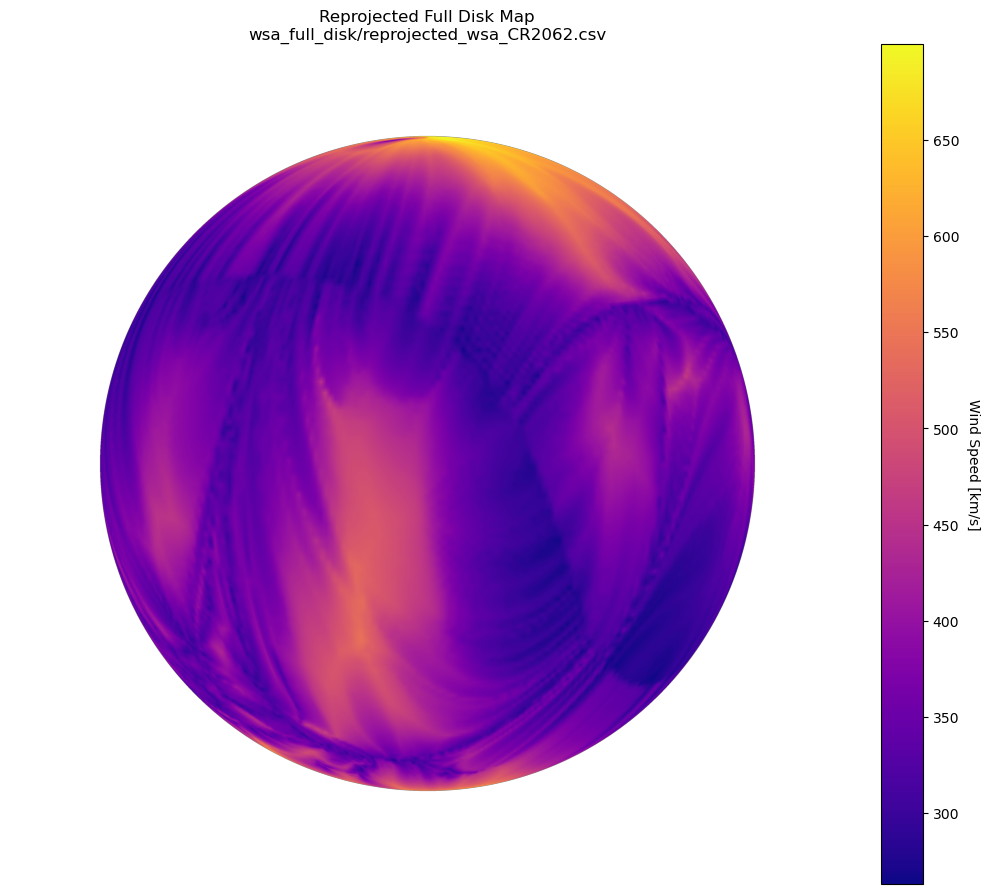

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# --- Configuration ---
# Replace this with the actual path to your CSV file
csv_file_path = 'wsa_full_disk/reprojected_wsa_CR2062.csv' 

def plot_reprojected_csv(filepath):
    print(f"Loading data from {filepath}...")
    print("This may take a moment due to the large file size (~300MB)...")
    
    try:
        # 1. Load the CSV data into a numpy array
        # delimiter=',' matches the format used in previous scripts
        full_disk_data = np.loadtxt(filepath, delimiter=',')
        
        print(f"Data loaded successfully. Shape: {full_disk_data.shape}")

        # 2. Plotting
        plt.figure(figsize=(10, 10))
        
        # 'origin=lower' places (0,0) at the bottom-left
        # 'cmap=plasma' is good for speed/heat maps
        plt.imshow(full_disk_data, cmap='plasma', origin='lower')
        
        # Add a colorbar
        cbar = plt.colorbar(fraction=0.046, pad=0.04)
        cbar.set_label('Wind Speed [km/s]', rotation=270, labelpad=15)
        
        plt.title(f"Reprojected Full Disk Map\n{filepath}")
        plt.axis('off')  # Turn off pixel coordinates axes for a cleaner look
        
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error reading or plotting file: {e}")

if __name__ == "__main__":
    plot_reprojected_csv(csv_file_path)